In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Create Synthetic Dataset

Predicting NCF Acceptance from SAT Score

In [ ]:
np.random.seed(5)
n_points = 10000
clip = lambda x : np.minimum(1600, np.maximum(400, x))

x_rejected = clip(np.random.normal(1257-100,100,n_points))
x_accepted = clip(np.random.normal(1257+100,100,n_points))
X = np.concatenate([x_rejected, x_accepted])
y = np.concatenate([np.zeros(n_points), np.ones(n_points)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

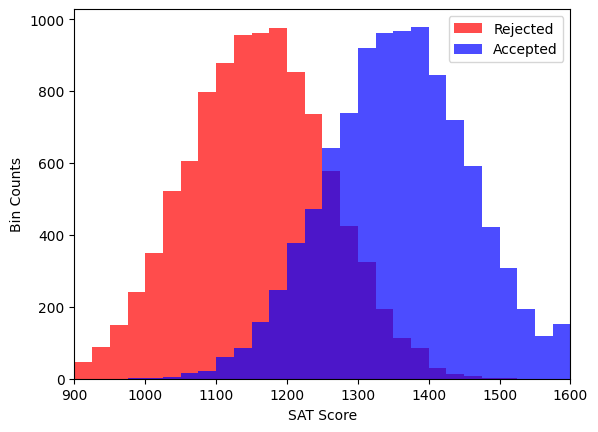

In [ ]:
counts_rejected, bins = np.histogram(x_rejected, np.linspace(900,1600,29))
counts_accepted, bins = np.histogram(x_accepted, np.linspace(900,1600,29))
bin_centers = bins[:-1] + np.diff(bins)[0]/2

plt.hist(x_rejected, bins=np.linspace(900,1600,29), histtype='stepfilled', alpha=.7, color='r', label='Rejected')
plt.hist(x_accepted, bins=np.linspace(900,1600,29), histtype='stepfilled', alpha=.7, color='b', label='Accepted')
plt.xlim(900,1600)
plt.xlabel('SAT Score')
plt.ylabel('Bin Counts')
plt.legend()
plt.show()

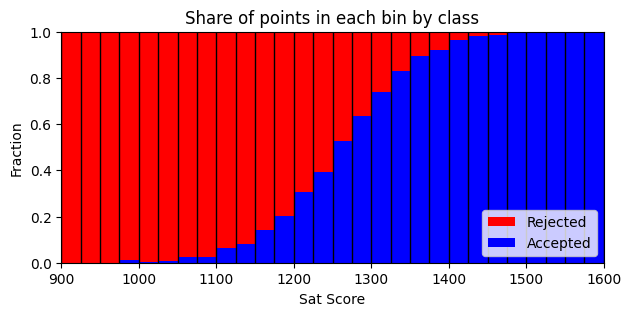

In [ ]:
plt.figure(figsize=[7,3])
plt.bar(bin_centers, counts_rejected/(counts_rejected+counts_accepted), bottom=counts_accepted/(counts_rejected+counts_accepted), color='r', width=25, label='Rejected')
plt.bar(bin_centers, counts_accepted/(counts_rejected+counts_accepted), color='b', width=25, label='Accepted')
plt.vlines(bins, 0, 1, color='k', lw=1)
plt.xlim(900,1600)
plt.xlabel('Sat Score')
plt.ylabel('Fraction')
plt.title('Share of points in each bin by class')
plt.legend(loc='lower right')
plt.show()

# Implementing your own Logistic Regression

### Sigmoid function

Let's start out easy by defining the sigmoid function. We defined it in class as:
$$\sigma(z) = \frac{e^z}{1+e^z}$$

In [ ]:
def sigmoid(z):
    """Compute the sigmoid of z.

    Parameter:
    - z: Logits (numpy array)
    """

    assert np.all(1+np.exp(z) > 0), z

    return np.exp(z) / (1 + np.exp(z))

# Test case: (sigmoid(0) should return .5)
# sigmoid(0)

### Prediction

Implement a function to calculate the model prediction
$$p(x) = \sigma(z) = \sigma(wx+b)$$

In [ ]:
def predict_prob(X, bias, weight):
  """Predict the probability of y=1 for a given input X

  Parameters:
  - X: Input features (numpy array)
  - bias: Bias term (float)
  - weight: Weight (float)

  Returns:
  - y_pred: Predicted probability of y=1 (numpy array)
  """
  z = bias + weight * X
  y_pred = sigmoid(z)
  return y_pred

### BCE Loss

We will use the Binary Cross Entropy (BCE) loss also known as the Negative Log Liklihood (nll) loss:
$$\mathscr L = -\frac{1}{N} \sum_{i=1}^N y^{(i)} \log(\hat y^{(i)}) + (1-y^{(i)}) \log(1-\hat y^{(i)})$$
Where $y^{(i)}$ are the true labels and $\hat y^{(i)}$ are the predicted labels `y_pred`. The superscript ${(i)}$ denotes the sample index: So $\hat y^{(0)}$ is the model's prediction for the label of the first sample in our dataset.

Please use numpy u-funcs for everything here, it can be done efficiently in one line.

In [ ]:
def compute_loss(y, y_pred):
    """Compute the log loss.

    Parameters:
    - y: Labels (numpy array)
    - y_pred: Predicted probability of class y=1 (numpy array)

    Returns:
    - Negative Log Loss (formula derived in class)
    """
    log_liklihood = np.mean(y * np.log(y_pred) + (1-y) * np.log(1-y_pred))
    return -log_liklihood

# Test case: (should return 0.0151265...)
# compute_loss(np.array([0,1]), np.array([.01, .98]))

0.015126521585510458

### Loss Function Gradients

In order to efficently optimize the model (find the minimimum of the loss function) we analytically calculate the gradient of the loss. This means taking partial derivatives of the loss with respect to each of the parameters: $b$ and $w_i$.
$$\frac{\partial \mathscr L}{\partial b} = \frac{1}{N}\sum_{i=1}^N (\hat y^{(i)} - y^{(i)})$$
$$\frac{\partial \mathscr L}{\partial w} = \frac{1}{N}\sum_{i=1}^N (\hat y^{(i)} - y^{(i)}) x^{(i)} $$

In [ ]:
def compute_gradient(X, y, y_pred):
    """Compute the gradient of the loss function with respect to the weights.

    Parameters:
    - X: Input features (numpy array)
    - y: Actual labels (numpy array)
    - y_pred: Predicted probabilities (numpy array)

    Returns:
    - Gradient of the loss function wrt bias and wrt weight
    """
    grad_bias = np.mean(y_pred-y)
    grad_weight = np.mean(X * (y_pred-y))

    return grad_bias, grad_weight

array([1201.12274869, 1123.91298481, 1400.0771187 , ..., 1519.0328642 ,
       1389.75255094, 1493.83811541])

### Training Loop

Here you will write a function which calculates

In [ ]:
def fit_logistic_regression(X, y, n_iterations=1000, learning_rate=0.1):
    """Perform logistic regression using gradient descent.

    Parameters:
    - X: Input features (numpy array)
    - y: Actual labels (numpy array)
    - num_iterations: Number of iterations for the optimization loop
    - learning_rate: Learning rate for the gradient descent

    Returns:
    - weights: Optimized weights (numpy array)
    - bias: Optimized bias term
    """
    # Initialize bias and weight to zero
    weight = 0
    bias = 0

    for i in range(n_iterations):
        # # Compute the predicted probabilities (y_pred) using predict_prob
        y_pred = predict_prob(X, bias, weight)

        # Compute the gradient of the loss function
        grad_bias, grad_weight = compute_gradient(X, y, y_pred)

        # Update the weight and bias
        bias   -= learning_rate * grad_bias
        weight -= learning_rate * grad_weight

        # Optionally, print the loss every 100 iterations
        if i % 100 == 0:
            print(f"Loss after iteration {i}: {compute_loss(y, y_pred).squeeze()}")

    return bias, weight

Now if we try running the function as is (below) we will get numerical errors. This comes from an overflow error when we try to exponentiate very large numbers while computing the sigmoid.

In [ ]:
bias, weight = fit_logistic_regression(X_train, y_train)

print("Optimized bias:", bias)
print("Optimized weight:", weight)

The solution is to standardize our features. This is typically done like computing "z-scores". Centering the data by subtracting the mean, and then scaling it by diving by the standard deviation:
$$X_\text{standardized} = \frac{X - \bar X}{\text{std}(X)}$$

If you've done everything right, running `fit_logistic_regression` with the standardized $X$ should work. Unfortunately the bias and weight are now only meaningful in the standardized world! Using them to predict unstandardized data wouldn't work.

I worked out how to unstandardize them by looking at how the predictions are calculated for standardized and unstandardized inputs. Let's denote standardized with a prime like: $X^\prime$.
$$\sigma(w^\prime X^\prime + b^\prime) = \sigma(wX+b)$$
So
$$w^\prime X^\prime + b^\prime = wX+b$$
Substituting for $X^\prime$
$$w^\prime \frac{X - \bar X}{\text{std}(X)} + b^\prime = wX+b$$
Rearranging, we get
$$\left(\frac{w^\prime}{\text{std}(X)}\right) X + \left(b^\prime - \frac{\bar X w^\prime}{\text{std}(X)}\right) = wX+b$$
Comparing the coefficents this tells us $w$ in terms of $w^\prime$
$$w = \frac{w^\prime}{\text{std}(X)}$$
And $b$ in terms of $b^\prime$
$$b = b^\prime - \frac{\bar X w^\prime}{\text{std}(X)} = b^\prime - \bar X w$$

Implement this in the `unstandardize_params` function

#### WARNING: Information Leakage

It is important to only standardize using information about the train data. Using information about the training and testing data will artificially improve your performance. One mild example of this is computing the mean of the entire dataset and using that to standardize, we must only use the training dataset. This is simulating how we will not know the mean and standard deviation of all the data we will see once the model is deployed.

In [ ]:
# Lets precompute these and use them as global variables
X_train_mean = X_train.mean()
X_train_std  = X_train.std()

def standardize_features(X):
    """Takes in a list of features and standardizes them using the precomputed mean and standard deviation of the training data"""
    return (X-X_train_mean)/X_train_std

def unstandardize_params(standardized_bias, standardized_weight):
    """Retrieve the real weight and bias from the model trained on the standardized data"""
    real_weight = standardized_weight / X_train_std
    real_bias = standardized_bias - X_train_mean * real_weight
    return real_bias, real_weight

bias, weight = fit_logistic_regression(standardize_features(X_train), y_train)
print(unstandardize_params(bias, weight))

Loss after iteration 0: 0.6931471805599453
Loss after iteration 100: 0.39773735752746936
Loss after iteration 200: 0.3720338740982941
Loss after iteration 300: 0.36518051903663784
Loss after iteration 400: 0.36272664533152676
Loss after iteration 500: 0.3617227411330366
Loss after iteration 600: 0.36128087780166884
Loss after iteration 700: 0.36107761594254006
Loss after iteration 800: 0.3609814422910951
Loss after iteration 900: 0.3609350833708557
(-24.37261277135525, 0.019404946726124316)


In [ ]:
def fit(X, y, n_iterations=1000, learning_rate=0.1):
    X_standardized = standardize_features(X)
    bias, weight = unstandardize_params(*fit_logistic_regression(X_standardized, y, n_iterations, learning_rate))
    return bias, weight

In [ ]:
bias, weight = fit(X_train, y_train)

print("Optimized bias:", bias)
print("Optimized weight:", weight)

Loss after iteration 0: 0.6931471805599453
Loss after iteration 100: 0.39773735752746936
Loss after iteration 200: 0.3720338740982941
Loss after iteration 300: 0.36518051903663784
Loss after iteration 400: 0.36272664533152676
Loss after iteration 500: 0.3617227411330366
Loss after iteration 600: 0.36128087780166884
Loss after iteration 700: 0.36107761594254006
Loss after iteration 800: 0.3609814422910951
Loss after iteration 900: 0.3609350833708557
Optimized bias: -24.37261277135525
Optimized weight: 0.019404946726124316


Run the function below, predicitng the likelihood that someone with a 1400 SAT Score will be accepted to NCF. The result should be 94%

In [ ]:
predict_prob(1400, bias, weight)

0.9423677152897865

In practice we need to convert this probability into a binary label. We do this by imposing a threshold on the probability, .5 is commonly used. This if we predict a greater than 50% chance that a given sample is in the $y=1$ class we say $y_\text{pred} = 1$, otherwise we predict $y_\text{pred} = 0$. More generally we can chose any threshold value:
$$\text{predict_class}(p) =
\begin{cases}
1 & \text{if } p > \text{thresh} \\
0 & \text{else}
\end{cases}$$
Implement this function. Be sure to write it so that it can accept either a float or a numpy array. This can be done in 1 line of course!

In [ ]:
def predict_class(y_pred, thresh=.5):
    return np.array(y_pred > thresh, dtype=int)

The code below draws the histogramed-estimate of probability of being accepted to NCF that we have seen above. Use your model to **draw a black line on top of this plot** which fits the curve as shown before in class.

Also plot a horizontal line using `plt.hlines` to indicate your threshold value

As usual this should be done with only numpy operations (no for loops)

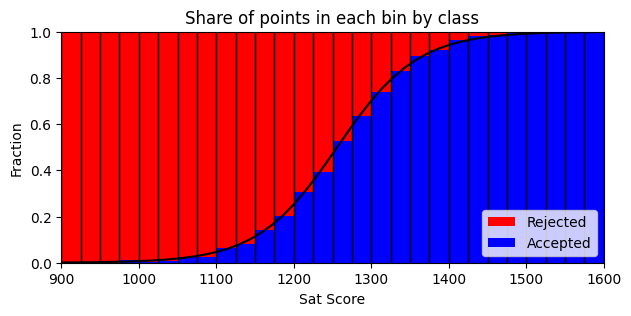

In [ ]:
plt.figure(figsize=[7,3])

# TODO Plot predicted probabilites curve
x_grid = np.linspace(900,1600)
plt.plot(x_grid, predict_prob(x_grid, bias, weight), color='k')

# TODO Plot threshold as a horizontal line


plt.bar(bin_centers, counts_rejected/(counts_rejected+counts_accepted), bottom=counts_accepted/(counts_rejected+counts_accepted), color='r', width=25, label='Rejected')
plt.bar(bin_centers, counts_accepted/(counts_rejected+counts_accepted), color='b', width=25, label='Accepted')
plt.vlines(bins, 0, 1, color='k', lw=1)
plt.xlim(900,1600)
plt.xlabel('Sat Score')
plt.ylabel('Fraction')
plt.title('Share of points in each bin by class')
plt.legend(loc='lower right')
plt.show()

## Compute the accuary of your prediction

Using the usual definition of accuracy, how does our model do on the test data?

In [ ]:
y_pred = predict_prob(X_test, bias, weight)

## ROC Curve

Create a ROC curve using sklearn and matplotlib. Also draw the diagonal which would correspond to a random classifier. Fix the limits of the axes and make the plot square using `plt.figure(figsize=...)`. Polish it up with x and y axis labels.

Finally draw a star on the plot indicating the point on the curve which corresponds to a threshold of 0.5

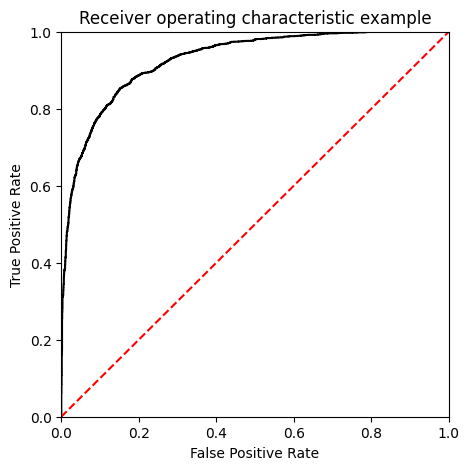

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=[5,5])
plt.plot(fpr, tpr, color='k')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.show()


## Exercise

Do some math to determine the exact value of your decision boundary. Meaning your class prediction cutoff or the SAT Score where you switch to predicting the other class. In other words, `thresh` is a horizontal line, the $x$ value (SAT Score) where it intersects the curve in the plot above is my decision boundary.

Compute it below from your chosen `thresh`.

Hint: This depends upon your weights and biases

Hint: Look at the function which gives your the probabilities

In [ ]:
tresh = .5

decision_bounary = ... # TODO

print(decision_bounary)

Briefly reflect upon the difference and similarities between this model and a Support Vector Machine

# Package all of this in a `LogisticRegressor` class

This should work in exactly the same way as the SKLearn models, complete with:
- `fit` method
- `predict_prob` method
- `predict_class` method
- And internally storing `X_train_mean` and `X_train_std` values.

In [ ]:
class LogisticRegressor:

    def __init__(self):
        pass

    def fit(self):
        pass

    def predict_prob(self):
        pass

## Test our your new creation on a new dataset


Create an instance of your `LogisticRegressor` class and fit it to the training data

Take that instance and use it to predict the testing data. (get `y_pred`)

Finally check the accuracy once again. (One line with numpy comparing `y_pred` and `y_test`)